# June 20, 2024: Connectivity analysis, discovering non-assortative blocks

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
import copy

from scipy import sparse, stats
from scipy.special import gammaln
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni
from itertools import combinations, permutations, product


import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import colorcet as cc
from mpl_toolkits.mplot3d import Axes3D

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240630-16:17:07,741 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 20 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
RECONST_method = '' #f'lds' #f'normal_dist'
if RECONST_method == '':
    GRAPH_type = f'correlation_graph'
    ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/{GRAPH_type}/density-{args.denst}'
    FC_path = f'{ROI_RESULTS_path}/corr_mats'
else: 
    GRAPH_type = f'reconstructed_graph/{RECONST_method}'
    ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/{GRAPH_type}'
    GRAPHS_path = f'{ROI_RESULTS_path}/graphs'

SBM_path = f'{ROI_RESULTS_path}/sbms'
NPY_path = f'{ROI_RESULTS_path}/npy'
os.system(f'mkdir -p {NPY_path}')
NII_path = f'{ROI_RESULTS_path}/niis'
os.system(f'mkdir -p {NII_path}/indiv')
os.system(f'mkdir -p {NII_path}/group/soft')
os.system(f'mkdir -p {NII_path}/group/entropy')
PNG_path = f'{ROI_RESULTS_path}/png'
os.system(f'mkdir -p {PNG_path}/group/morphospace')
HTML_path = f'{ROI_RESULTS_path}/htmls'
os.system(f'mkdir -p {HTML_path}/group/soft/indexes')
os.system(f'mkdir -p {HTML_path}/group/entropy/indexes')
CSV_path = f'{ROI_RESULTS_path}/csv'
os.system(f'mkdir -p {CSV_path}/group/roi_order')

0

In [4]:
roi_names = pd.read_csv(f'{PARCELS_path}/{DESC}_desc-names.csv', names=['label', 'name'], delimiter='\t')
roi_names

label                                  name
0        1       L-Primary motor area (MOp,1071)
1        2  L-Postrhinal area (VISpor,312782714)
2        3      L-Primary visual area (VISp,471)
3        4     L-Secondary motor area (MOs,1079)
4        5            L-Visceral area (VISC,763)
..     ...                                   ...
157    158         R-Cerebellar cortex (CBX,528)
158    159         R-Cerebellar cortex (CBX,528)
159    160         R-Cerebellar cortex (CBX,528)
160    161         R-Cerebellar cortex (CBX,528)
161    162         R-Cerebellar cortex (CBX,528)

[162 rows x 2 columns]

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [6]:
# collection of graphs
files = sorted(glob.glob(f'{ROI_RESULTS_path}/corr_mats/*'))
graphs_df = []
for file in tqdm(files):
    fs = file.split('/')
    ssr = '_'.join(fs[-1].split('_')[:2])
    df = pd.DataFrame({
        'ssr': [ssr],
        'graph':[np.array(gt.adjacency(gt.load_graph(file)).todense())],
    })
    graphs_df.append(df)
graphs_df = pd.concat(graphs_df).reset_index(drop=True)
# graphs_df

100%|██████████| 30/30 [00:00<00:00, 944.29it/s]


In [7]:
def load_modes(args, model):
    args.dc, args.sbm = model
    SBM = f'sbm-{args.dc}-{args.sbm}'
    with open(f'{NPY_path}/{SBM}_desc-group-modes.npy', 'rb') as f:
        [dfs, mode_df] = pickle.load(f)
    return args, SBM, dfs, mode_df

In [8]:
def get_block_lengths(args, bs_df, level=0):
    return bs_df[level].groupby((bs_df[level] != bs_df[level].shift()).cumsum()).size()

def get_nested_block_edges(args, bs_df):
    bndrs_df = bs_df[1].groupby(bs_df[1]).size()
    bndrs = [0] + bndrs_df.cumsum().to_list()
    return bndrs

def get_nested_block_lengths(args, bs_df):
    block_lens = []
    for level in bs_df.columns:
        block_lens += [get_block_lengths(args, bs_df, level)]
    return block_lens

def get_roi_idxs(args, bs_df, level=0):
    roi_idxs = []
    for label in bs_df[level].unique():
        df = pd.DataFrame({
            'label':[label],
            'idxs':[bs_df[level][bs_df[level] == label].index.to_list()],
        })
        roi_idxs.append(df)
    roi_idxs = pd.concat(roi_idxs).reset_index(drop=True)
    return roi_idxs

def get_nested_roi_idxs(args, bs_df):
    roi_idxs = []
    for level in bs_df.columns:
        roi_idxs += [get_roi_idxs(args, bs_df, level)]
    return roi_idxs

def fill_denst_block_graphs(args, g, denst_g, block_g, roi_idxs, i, j):
    label1, idxs1 = roi_idxs.iloc[i]
    label2, idxs2 = roi_idxs.iloc[j]
    IJ = np.ix_(idxs1, idxs2)
    blk = g[IJ]
    d = np.sum(blk) / blk.size
    denst_g[IJ] = d
    block_g[i, j] = d
    return denst_g, block_g

def get_denst_block_graph(args, g, roi_idxs):
    denst_g = np.zeros_like(g)
    block_g = np.zeros((len(roi_idxs), len(roi_idxs)))
    # upper triangle
    row_pairs = list(combinations(roi_idxs.index, 2))
    for i, j in row_pairs:
        denst_g, block_g = fill_denst_block_graphs(
            args, g, denst_g, block_g, roi_idxs, i, j
        )
    # lower triangle
    denst_g = (denst_g + denst_g.T) 
    block_g = (block_g + block_g.T)
    # diagnol
    for i in roi_idxs.index:
        denst_g, block_g = fill_denst_block_graphs(
            args, g, denst_g, block_g, roi_idxs, i, i
        )
    return denst_g, block_g

def get_density_block_graphs(args, graphs_df, roi_idxs, roi_order, level=0):
    densts_df = []
    for idx_graph, row in tqdm(graphs_df.iterrows()):
        g = row['graph']
        denst_g, block_g = get_denst_block_graph(args, g, roi_idxs)
        g_ = g[np.ix_(roi_order, roi_order)]
        denst_g_ = denst_g[np.ix_(roi_order, roi_order)]
        
        df = pd.DataFrame({
            'ssr':[row['ssr']],
            'g': [g_],
            f'denst_level{level}':[denst_g_],
            f'block_level{level}':[block_g],
        })
        densts_df.append(df)
    densts_df = pd.concat(densts_df).reset_index(drop=True)
    return densts_df

def get_nested_density_block_graphs(args, graphs_df, roi_idxs, roi_order):
    densts_df = []
    for level in bs_df.columns:
        densts_df.append(
            get_density_block_graphs(args, graphs_df, roi_idxs[level], roi_order, level)
        )
    densts_df = pd.concat(densts_df, axis=1)
    return densts_df.loc[:, ~densts_df.columns.duplicated()]

def plot_avg_denst_graph(args, ax, densts_df, bndrs, level=0):
    cmap = cc.cm.CET_L20
    denst_g_avg = np.mean(np.stack(densts_df['denst'].to_list()), axis=0)
    sns.heatmap(denst_g_avg, ax=ax, cmap=cmap)
    ax.set_title(f'{SBM}_level-{level}') if level >= 0 else ax.set_title(f'{SBM}')
    ax.set_xticks(bndrs, minor=False)
    ax.set_yticks(bndrs, minor=False)
    ax.grid(True)
    return denst_g_avg

In [9]:
def plot_density_graphs(args, densts_df):
    ncols = 2
    nrows = len(densts_df)
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, 
        figsize=(5*ncols, 4*nrows), dpi=90,
    )
    fig.tight_layout(h_pad=4, w_pad=1)

    for idx_graph, row in tqdm(densts_df.iterrows()):
        
        ssr, g = row[['ssr', 'g']]
        ds = row[row.index[2::2]].to_list()
        
        ax = axs[idx_graph, 0]
        cmap = cc.cm.CET_L2
        sns.heatmap(g, square=True, ax=ax, cmap=cmap)
        ax.set(title=f'block graph', ylabel=f'{ssr} \n roi.', xlabel=f'roi')

        for level in range(len(ds)):
            ax = axs[idx_graph, level+1]
            cmap = cc.cm.CET_L20 #mpl.colormaps['Blues'] #mpl.colormaps['viridis']
            sns.heatmap(ds[level], square=True, ax=ax, cmap=cmap)
            ax.set(title=f'density graph', ylabel=f'roi', xlabel=f'roi')
    return fig

def plot_nested_density_graphs(args, densts_df):
    ncols = 3
    nrows = len(densts_df)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=90)
    fig.tight_layout(h_pad=4, w_pad=1)

    for idx_graph, row in tqdm(densts_df.iterrows()):
        
        ssr, g = row[['ssr', 'g']]
        ds = row[row.index[2::2]].to_list() # density graphs (at all levels)
        
        ax = axs[idx_graph, 0]
        cmap = cc.cm.CET_L2
        sns.heatmap(g, square=True, ax=ax, cmap=cmap)
        ax.set_xticks(bndrs, minor=False)
        ax.set_yticks(bndrs, minor=False)
        ax.grid(True)
        ax.set(title=f'block graph', ylabel=f'{ssr} \n roi.', xlabel=f'roi')

        for level in range(len(ds)):
            ax = axs[idx_graph, level+1]
            cmap = cc.cm.CET_L20 #mpl.colormaps['Blues'] #mpl.colormaps['viridis']
            sns.heatmap(ds[level], square=True, ax=ax, cmap=cmap)
            ax.set_xticks(bndrs, minor=False)
            ax.set_yticks(bndrs, minor=False)
            ax.grid(True)
            ax.set(title=f'density graph, level{level}', ylabel=f'roi', xlabel=f'roi')
    return fig

In [10]:
def get_M(args, drr, dss, drs, colors_list):
    M = np.zeros((drr.shape[0], 4))
    M[:, 0] = np.minimum(drr, dss) > drs # arrostative
    M[:, 3] = np.maximum(drr, dss) < drs # disassortative
    # core-periphery
    M[:, 1] = (drr > drs) & (drs > dss) # rr is core
    M[:, 2] = (dss > drs) & (drs > drr) # ss is core
    return M

In [11]:
def morphospace(args, densts_df, roi_idxs, level=0):
    block_gs = np.stack(densts_df[f'block_level{level}'].to_list(), axis=0)
    
    morpho_df = []
    indexes_labels = zip(
        list(combinations(roi_idxs.index, 2)), 
        list(combinations(roi_idxs['label'], 2))
    )
    for (r, s), (label1, label2) in indexes_labels:
        drr = block_gs[:, r, r]
        dss = block_gs[:, s, s]
        drs = block_gs[:, r, s]
        coords = np.stack([drr, dss, drs], axis=-1)
        M = get_M(args, drr, dss, drs, colors_list)
        cs = [colors_list[m] for m in np.argmax(M, axis=-1)]
        M_df = pd.DataFrame(
            data=M, 
            columns=['a', 'c', 'p', 'd']
        )
        df = pd.DataFrame({
            'r':[r],
            's':[s],
            'labelr':[label1],
            'labels':[label2],
            'coords':[coords],
            'colors':[cs],
            'M':[M_df],
        })
        morpho_df.append(df)
    morpho_df = pd.concat(morpho_df).reset_index(drop=True)
    return morpho_df
    
def nested_morphospace(args, densts_df, roi_idxs):
    morpho_dfs = []
    for level in range(len(roi_idxs)):
        morpho_dfs.append(morphospace(args, densts_df, roi_idxs[level], level))
    return morpho_dfs

In [12]:
def plot_morphospace(args, morpho_df):
    L = morpho_df['s'].max()+1
    nrows = L
    ncols = L
    fig = plt.figure(figsize=(5*ncols, 4*nrows))
    fig.tight_layout()

    for idx, row in morpho_df.iterrows():
        r, s, lr, ls, coords, cs, M = row
        
        idx_ax = r * L + s + 1
        ax = fig.add_subplot(nrows, ncols, idx_ax, projection='3d')
        ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=cs)
        ax.set(xlabel="$C_{" + f'{lr},{lr}' + "}$", ylabel="$C_{" + f'{ls},{ls}' + "}$", zlabel="$C_{" + f'{lr},{ls}' + "}$")
        
        idx_ax = s * L + r + 1
        ax = fig.add_subplot(nrows, ncols, idx_ax)
        Ms = np.stack([M.sample(n=len(M), replace=True, random_state=rs).sum().values for rs in range(1000)])
        lci = np.percentile(Ms, 2.5, axis=0)
        uci = np.percentile(Ms, 97.5, axis=0)
        orig_s = M.sum().values
        yerr = [orig_s - lci, uci - orig_s]
        ax.bar(x=M.sum().index, height=M.sum().values, yerr=yerr, capsize=5.0, alpha=0.8, color=colors_list)
        ax.set(title=f'{lr}, {ls}')
    return fig

def plot_nested_morphospace(args, morpho_df):
    figs = []
    for level in range(len(morpho_df)):
        figs.append(plot_morphospace(args, morpho_df[level]))
    return figs

mode 0


30it [00:00, 43.23it/s]
30it [00:00, 363.86it/s]
30it [02:26,  4.88s/it]


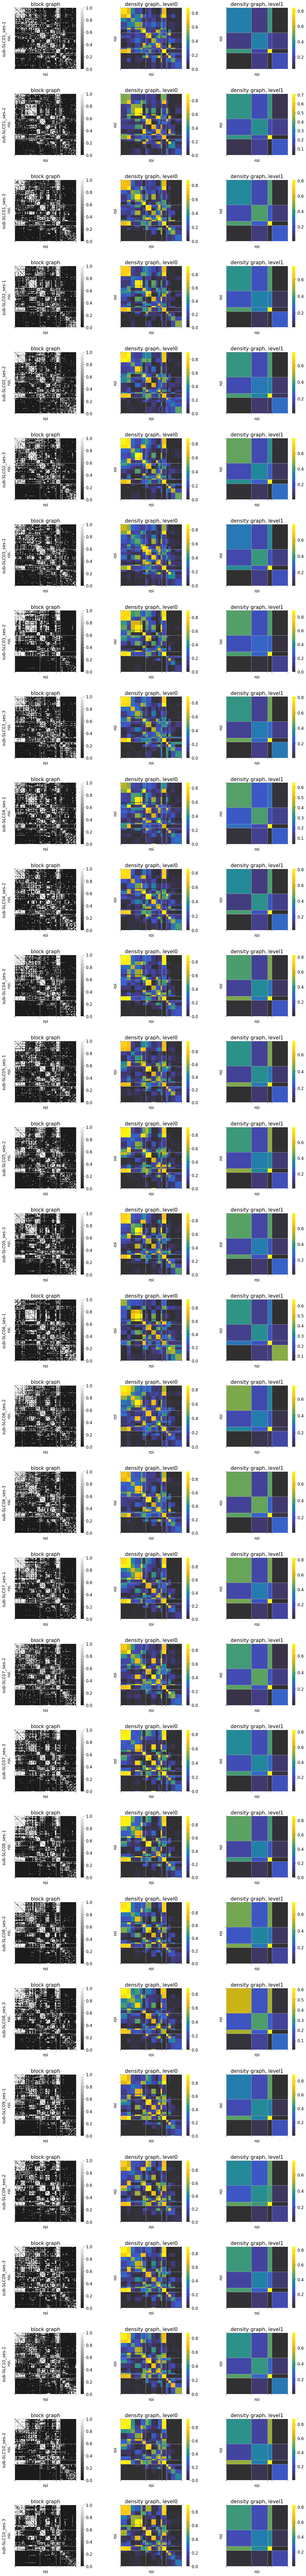

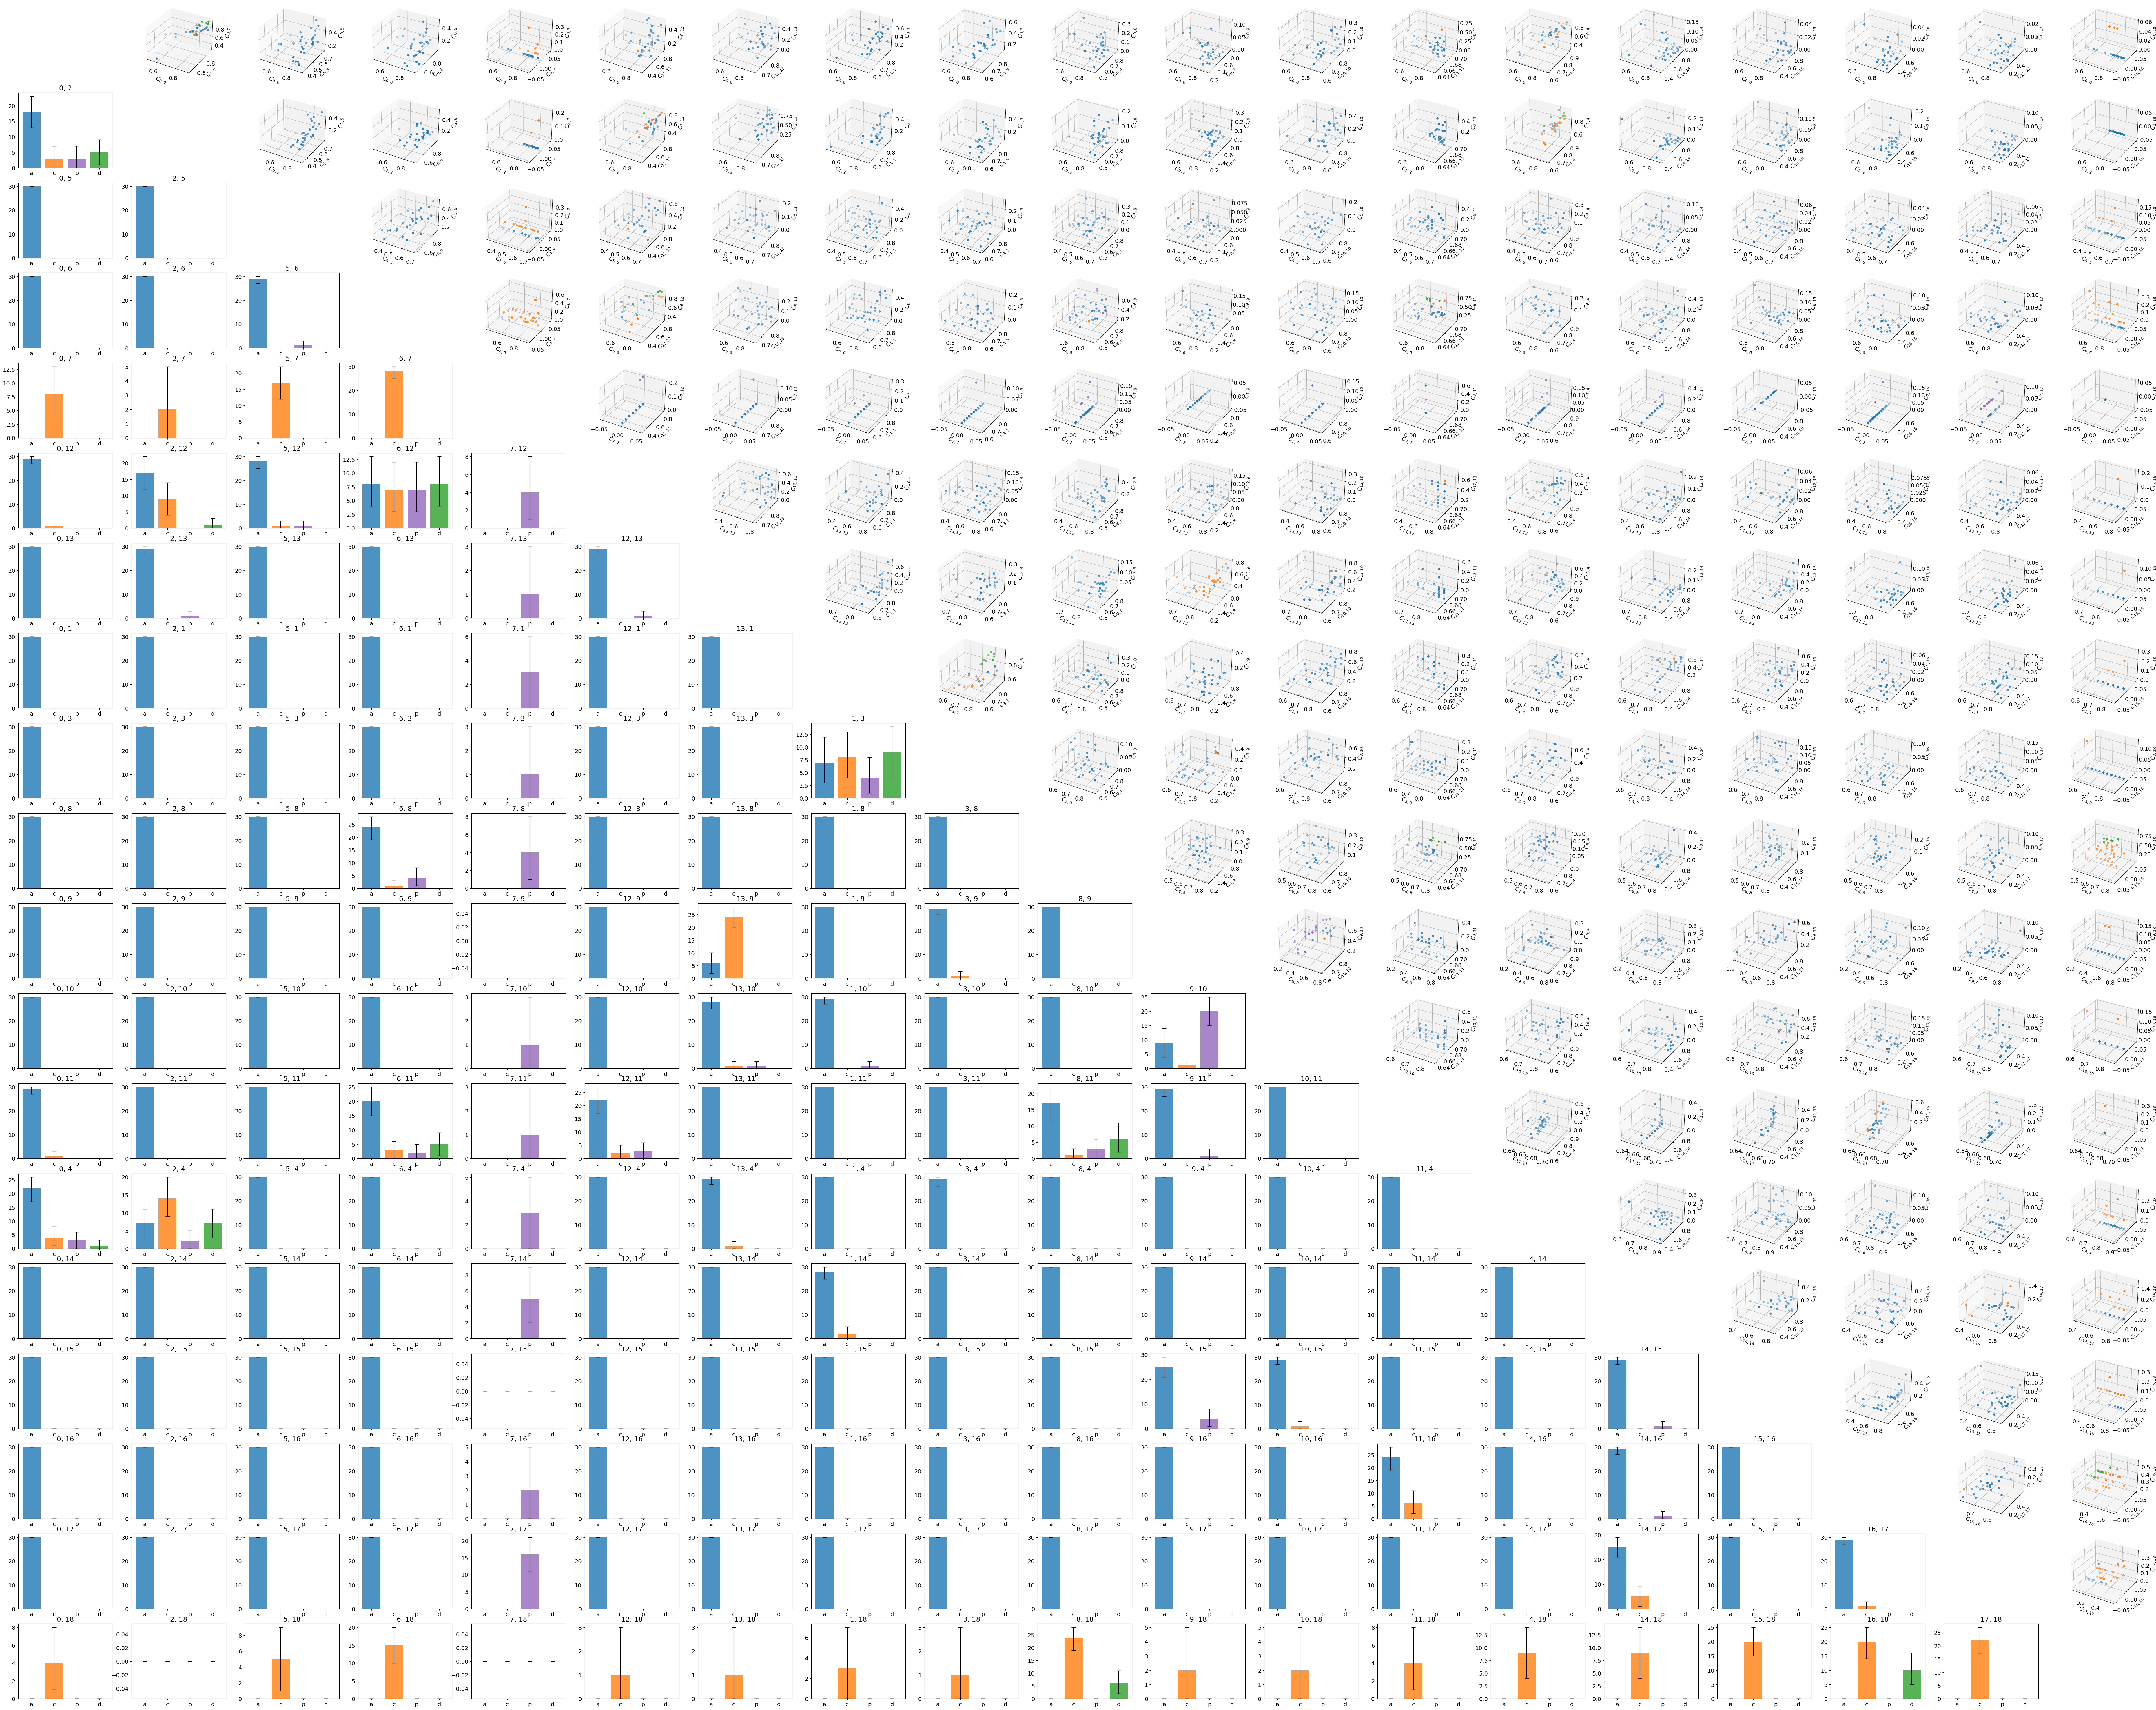

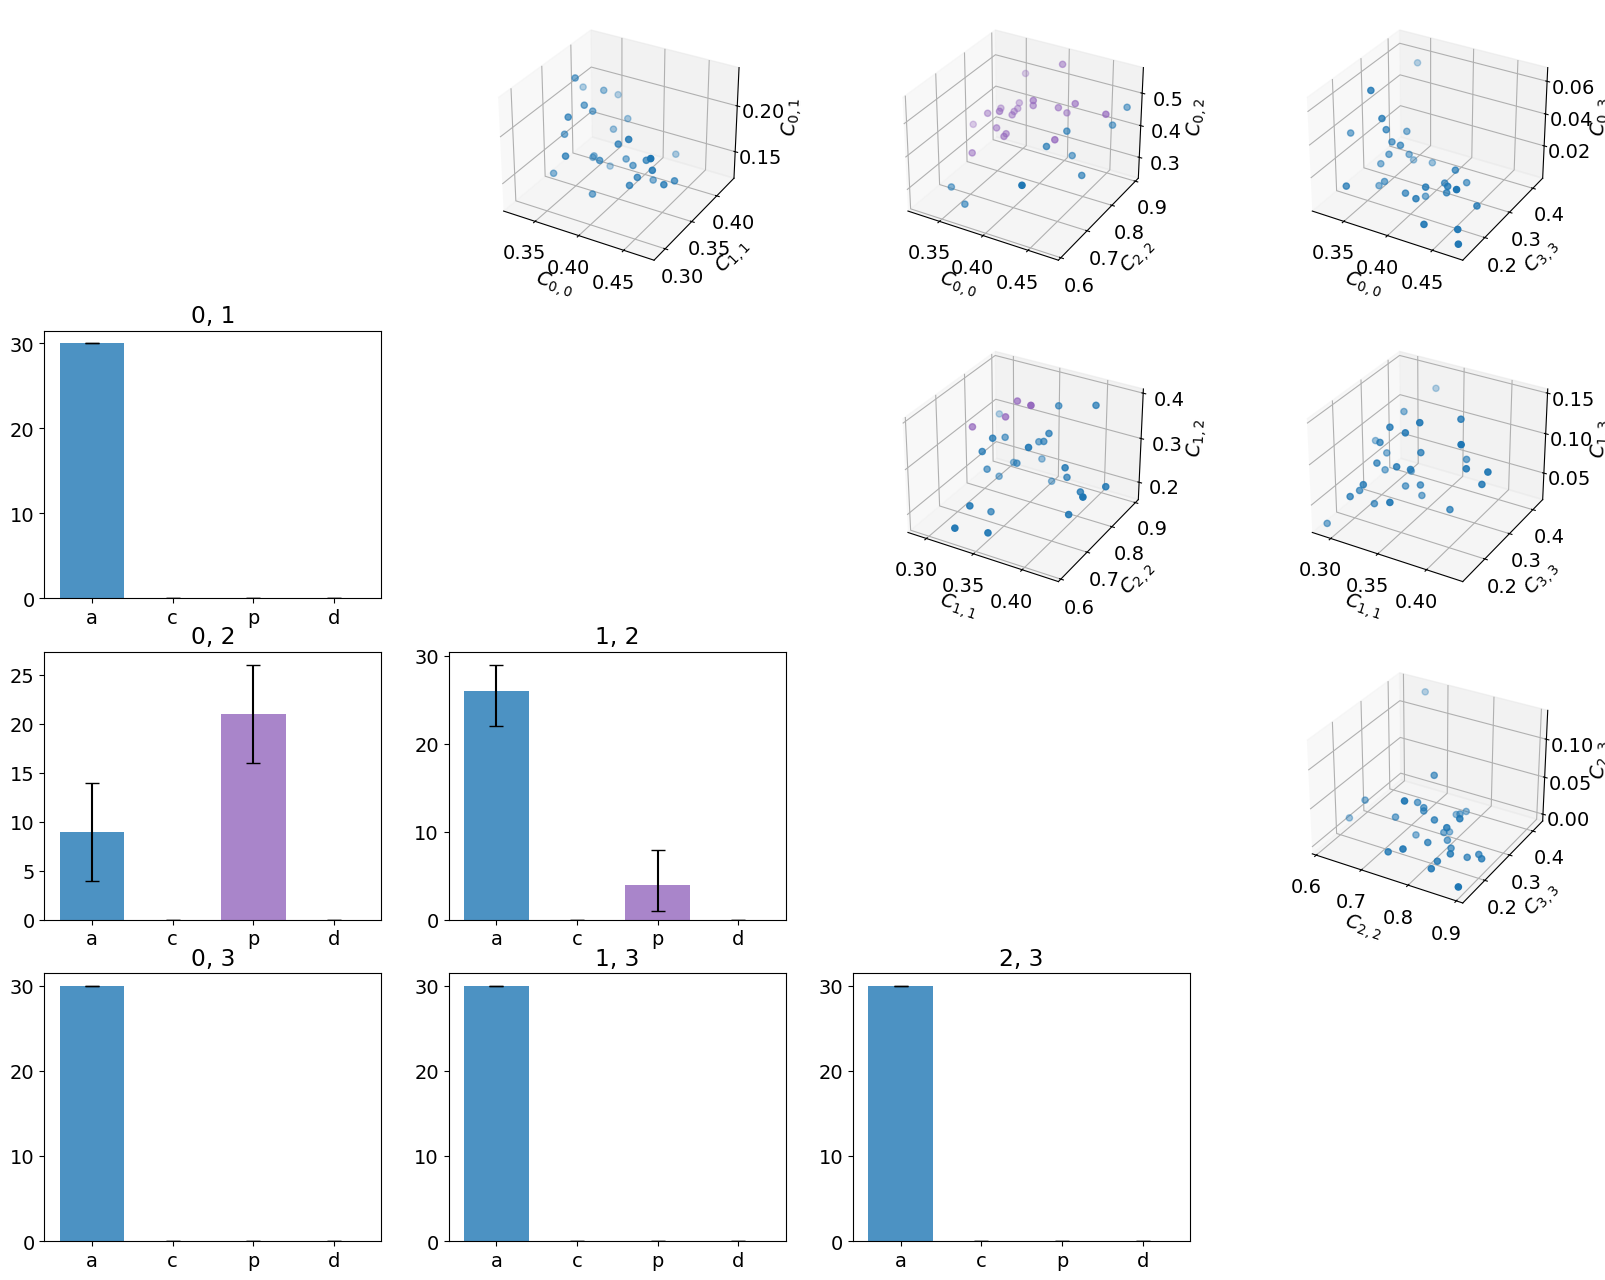

In [13]:
colors_list = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green']

model = ('nd', 'h')
args, SBM, dfs, mode_df = load_modes(args, model)

for idx_mode, row_mode in mode_df.iterrows():
    print(f'mode {idx_mode}')
    omega, bs = row_mode[['omega', 'b']]
    bs = np.stack(bs, axis=-1)
    
    if args.sbm in ['a', 'd']:
        bs_df = pd.DataFrame(bs)
        bs_df = bs_df.sort_values(by=list(bs_df.columns)[::-1]) # sort first with higher levels
        
        roi_order = bs_df.index.to_list()
        block_lens = get_block_lengths(args, bs_df)
        roi_idxs = get_roi_idxs(args, bs_df)
        
        densts_df = get_density_block_graphs(args, graphs_df, roi_idxs, roi_order)
        fig_denst = plot_density_graphs(args, densts_df)
        fig_denst.savefig(
            f'{PNG_path}/group/morphospace/{SBM}_mode-{idx_mode}_desc-density-graphs.png', 
            bbox_inches='tight', transparent=True,
        )
        
        morpho_df = morphospace(args, densts_df, roi_idxs, level=0)
        fig_morpho = plot_morphospace(args, morpho_df)
        fig_morpho.savefig(
            f'{PNG_path}/group/morphospace/{SBM}_mode-{idx_mode}_desc-morphospace.png', 
            bbox_inches='tight', transparent=True,
        )
        
        bs_df = pd.concat([bs_df, roi_names.iloc[bs_df.index, :]], axis=1)
        bs_df.to_csv(
            f'{CSV_path}/group/roi_order/{SBM}_mode-{idx_mode}_desc-roi-order.csv',
            sep='\t',
            index=False,
        )
        
    if args.sbm in ['h']:
        bs_df = pd.DataFrame(bs[:, :2])
        bs_df = bs_df.sort_values(by=list(bs_df.columns)[::-1]) # sort first with higher levels
        
        roi_order = bs_df.index.to_list()
        bndrs = get_nested_block_edges(args, bs_df)
        block_lens = get_nested_block_lengths(args, bs_df)
        roi_idxs = get_nested_roi_idxs(args, bs_df)
        
        densts_df = get_nested_density_block_graphs(args, graphs_df, roi_idxs, roi_order)
        fig_denst = plot_nested_density_graphs(args, densts_df)
        fig_denst.savefig(
            f'{PNG_path}/group/morphospace/{SBM}_mode-{idx_mode}_desc-density-graphs.png', 
            bbox_inches='tight', transparent=True,
        )
        
        morpho_df = nested_morphospace(args, densts_df, roi_idxs)
        figs_morpho = plot_nested_morphospace(args, morpho_df)
        for level in range(len(figs_morpho)):
            figs_morpho[level].savefig(
                f'{PNG_path}/group/morphospace/{SBM}_mode-{idx_mode}_level-{level}_desc-morphospace.png', 
                bbox_inches='tight', transparent=True,
            )
        
        bs_df = pd.concat([bs_df, roi_names.iloc[bs_df.index, :]], axis=1)
        bs_df.to_csv(
            f'{CSV_path}/group/roi_order/{SBM}_mode-{idx_mode}_desc-roi-order.csv',
            sep='\t',
            index=False,
        )